Definition of **pipeline** class according to scikit-learn is:

Sequentially apply a list of transforms and a final estimator. Intermediate steps of pipeline must implement fit and transform methods and the final estimator only needs to implement fit.

### <font color = black> Data Exploration 


In [4]:
#import modules

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#read data

winedf = pd.read_csv('winequality-red.csv',sep=';')
# print winedf.isnull().sum() # check for missing data
winedf.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


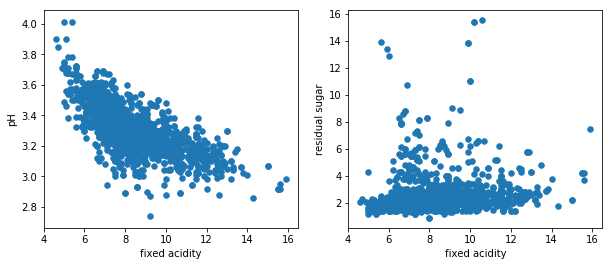

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

ax1 = winedf.plot.scatter('fixed acidity', 'pH', ax=ax[0],s=30)
ax2 = winedf.plot.scatter('fixed acidity', 'residual sugar', ax=ax[1],s=30)

plt.show()

As expected acidity and pH has a high negative correlation compared to residual sugar and acidity. Once we are familiar and have played around enough with the data-set, let’s discuss and implement pipeline.

As the name suggests, **pipeline class allows sticking multiple processes into a single scikit-learn estimator. *pipeline* class has fit, predict and score method just like any other estimator** (ex. LinearRegression).

To implement pipeline, as usual we separate features and labels from the data-set at first.

In [27]:
X=winedf.drop(['quality'],axis=1)
Y=winedf['quality']

Let's use a fitting algorithm that needs scaling known as SVM (**Support Vector Machine**)

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

Here we are using *StandardScaler*, which subtracts the mean from each features and then scale to unit variance.

Now we are ready to create a pipeline object by providing with the list of steps. Our steps are — standard scalar and support vector machine. These steps are list of tuples consisting of name and an instance of the transformer or estimator. Let’s see the piece of code below for clarification -

In [29]:
steps = [('scaler', StandardScaler()), ('SVM', SVC())]

from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps) # define the pipeline object.

The strings (‘scaler’, ‘SVM’) can be anything, as these are just names to identify clearly the transformer or estimator. We can use make_pipeline instead of Pipeline to avoid naming the estimator or transformer. The *final step has to be an estimator in this list of tuples*.

We divide the data-set into training and test-set with a random_state=30 .

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=30, stratify=Y)

It’s necessary to use stratify as I’ve mentioned before that the labels are imbalanced as most of the wine quality falls in the range 5,6. You can check using pandas value_counts() which returns objects containing counts of unique values.

In [33]:
winedf['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

**SVM is usually optimized using two parameters gamma,C; let’s define a parameter grid that we will use in GridSearchCV.**

In [34]:
parameteres = {'SVM__C':[0.001,0.1,10,100,10e5], 'SVM__gamma':[0.1,0.01]}

Now we instantiate the GridSearchCV object with pipeline and the parameter space with 5 folds cross validation.

In [36]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipeline, param_grid=parameteres, cv=5)

We can use this to fit on the training data-set and test the algorithm on the test-data set. Also we can find the best fit parameters for the SVM as below

In [37]:
grid.fit(X_train, y_train)
print("score = %3.2f" %(grid.score(X_test,y_test)))
print(grid.best_params_)

score = 0.67
{'SVM__C': 10, 'SVM__gamma': 0.1}


**Why Pipeline**

It surely helps to enforce desired order of application steps which in turn helps in reproducibility and creating a convenient work-flow. But, there is something more to pipeline, as we have used grid search cross validation, we can understand it better.

The pipeline object in the example above was created with StandardScalerand SVM . Instead of using pipeline if they were applied separately then for StandardScaler one can proceed as below

scale = StandardScaler().fit(X_train)
X_train_scaled = scale.transform(X_train)
grid = GridSearchCV(SVC(), param_grid=parameteres, cv=5)
grid.fit(X_train_scaled, y_train)

Here we see the intrinsic problem of applying a transformer and an estimator separately where the parameters for estimator (SVM) are determined using GridSearchCV . The scaled features used for cross-validation is separated into test and train fold but the test fold already contains the info about training set as the whole training set (X_train) was used for standardization. In a simpler note when SVC.fit() is done using cross-validation the features already include info from the test-fold as StandardScaler.fit() was done on the whole training set.

One can bypass this oversimplification by using pipeline. Using pipeline we glue together the StandardScaler() and SVC() and this ensure that during cross validation the StandardScaler is fitted to only the training fold, exactly similar fold used for SVC.fit() 